# Load libraries

In [45]:
import pickle
from sklearn.ensemble import AdaBoostClassifier
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import math , time , random , datetime
# keeps the plots in one place. calls image as static pngs
%matplotlib inline 
import matplotlib.pyplot as plt # side-stepping mpl backend
import matplotlib.gridspec as gridspec # subplots
import mpld3 as mpl
import missingno
#Import models from scikit learn module:
import sklearn.model_selection
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold   #For K-fold cross validation
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn import metrics
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LinearRegression,LogisticRegression,SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from catboost import CatBoostClassifier , Pool,cv
from sklearn.svm import LinearSVC
import warnings
warnings.filterwarnings('ignore')

In [46]:
df = pd.read_csv("patient.csv",header = 0)#header=0 , which means the first row of the CSV file will be treated as column names
column_names = list(df.columns)
df = df.rename(columns={'MCP.1': 'MCP_1'})


In [47]:
df.head()


,Age,BMI,Glucose,Insulin,HOMA,Leptin,Adiponectin,Resistin,MCP_1,Classification
0,48,23.500000,70,2.707,0.467409,8.8071,9.702400,7.99585,417.114,1
1,83,20.690495,92,3.115,0.706897,8.8438,5.429285,4.06405,468.786,1
2,82,23.124670,91,4.498,1.009651,17.9393,22.432040,9.27715,554.697,1
3,68,21.367521,77,3.226,0.612725,9.8827,7.169560,12.76600,928.220,1
4,86,21.111111,92,3.549,0.805386,6.6994,4.819240,10.57635,773.920,1


In [25]:
# size of the dataframe
len(df)


116

In [48]:
df.tail()

,Age,BMI,Glucose,Insulin,HOMA,Leptin,Adiponectin,Resistin,MCP_1,Classification
111,45,26.85,92,3.33,0.755688,54.68,12.10,10.96,268.23,2
112,62,26.84,100,4.53,1.117400,12.45,21.42,7.32,330.16,2
113,65,32.05,97,5.73,1.370998,61.48,22.54,10.33,314.05,2
114,72,25.59,82,2.82,0.570392,24.96,33.75,3.27,392.46,2
115,86,27.18,138,19.91,6.777364,90.28,14.11,4.35,90.09,2


In [49]:
df.Classification.unique()

array([1, 2], dtype=int64)

# Explore data


In [50]:
df.describe()

,Age,BMI,Glucose,Insulin,HOMA,Leptin,Adiponectin,Resistin,MCP_1,Classification
count,116.000000,116.000000,116.000000,116.000000,116.000000,116.000000,116.000000,116.000000,116.000000,116.000000
mean,57.301724,27.582111,97.793103,10.012086,2.694988,26.615080,10.180874,14.725966,534.647000,1.551724
std,16.112766,5.020136,22.525162,10.067768,3.642043,19.183294,6.843341,12.390646,345.912663,0.499475
min,24.000000,18.370000,60.000000,2.432000,0.467409,4.311000,1.656020,3.210000,45.843000,1.000000
25%,45.000000,22.973205,85.750000,4.359250,0.917966,12.313675,5.474283,6.881763,269.978250,1.000000
50%,56.000000,27.662416,92.000000,5.924500,1.380939,20.271000,8.352692,10.827740,471.322500,2.000000
75%,71.000000,31.241442,102.000000,11.189250,2.857787,37.378300,11.815970,17.755207,700.085000,2.000000
max,89.000000,38.578759,201.000000,58.460000,25.050342,90.280000,38.040000,82.100000,1698.440000,2.000000


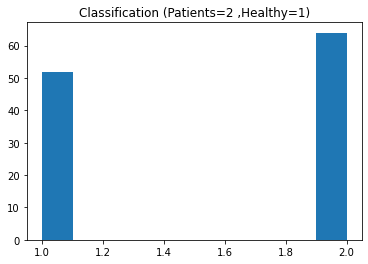

In [29]:
df.describe()
plt.hist(df['Classification'])
plt.title('Classification (Patients=2 ,Healthy=1)')
plt.show()

In [51]:
features_mean=list(df.columns[0:11])
# split dataframe into two based on diagnosis
dfM=df[df['Classification'] ==1]
dfB=df[df['Classification'] ==2]

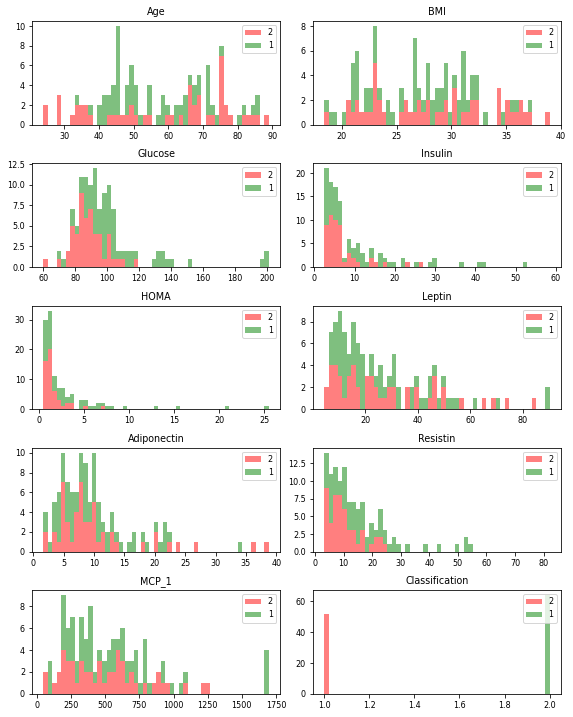

In [52]:
#Stack the data
plt.rcParams.update({'font.size': 8})
fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(8,10))
axes = axes.ravel()
for idx,ax in enumerate(axes):
    ax.figure
    binwidth= (max(df[features_mean[idx]]) - min(df[features_mean[idx]]))/50
    ax.hist([dfM[features_mean[idx]],dfB[features_mean[idx]]], bins=np.arange(min(df[features_mean[idx]]), max(df[features_mean[idx]]) + binwidth, binwidth) , alpha=0.5,stacked=True,  label=['2','1'],color=['r','g'])
    ax.legend(loc='upper right')
    ax.set_title(features_mean[idx])

plt.tight_layout()    
plt.show()



# plot graphics of missing data


<AxesSubplot:>

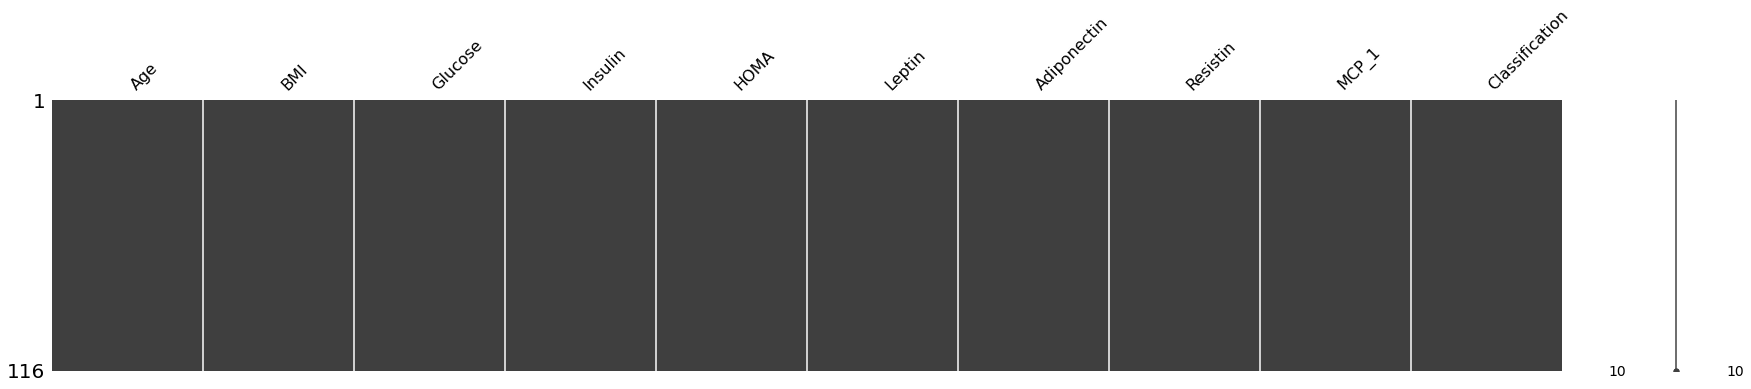

In [53]:
missingno.matrix(df,figsize=(30,5))

# creating a training set


In [54]:
x_train=df.drop('Classification',axis=1)
y_train=df.Classification

# model classification


In [55]:

def fit_ml_algo(algo,x_train,y_train,cv):
  #One Pass
  model=algo.fit(x_train,y_train)
  acc=round(model.score(x_train,y_train)*100,2)
  #Cross Validation
  train_pred=sklearn.model_selection.cross_val_predict(algo,x_train,y_train,cv=cv )
  #Cross Validation accuarcy metric
  acc_cv=round(metrics.accuracy_score(y_train,train_pred)*100,2)
  return train_pred ,acc, acc_cv

# Logistic Regression model


In [56]:
#Logistic Regression
start_time=time.time()
train_pred_log,acc_log,acc_cv_log=fit_ml_algo(LogisticRegression(),x_train,y_train,10)
log_time=time.time()-start_time
print('Accuracy (percent)',acc_log)
print('Accuracy for cross validation(percent)',acc_cv_log)
print('Runing Time',datetime.timedelta(seconds=log_time))

Accuracy (percent) 78.45
Accuracy for cross validation(percent) 64.66
Runing Time 0:00:00.469248


# K_Nearst neighbors 

In [57]:
#knn
start_time=time.time()
train_pred_knn,acc_knn,acc_cv_knn=fit_ml_algo(KNeighborsClassifier(),x_train,y_train,10)
log_time=time.time()-start_time
print('Accuracy (percent)',acc_log)
print('Accuracy for cross validation(percent)',acc_cv_log)
print('Runing Time',datetime.timedelta(seconds=log_time))

Accuracy (percent) 78.45
Accuracy for cross validation(percent) 64.66
Runing Time 0:00:00.093385


# Linear support vector machines

In [58]:
#LSVM
start_time=time.time()
train_pred_svc,acc_svc,acc_cv_svc=fit_ml_algo(LinearSVC(),x_train,y_train,10)
log_time=time.time()-start_time
print('Accuracy (percent)',acc_svc)
print('Accuracy for cross validation(percent)',acc_cv_svc)
print('Runing Time',datetime.timedelta(seconds=log_time))

Accuracy (percent) 56.03
Accuracy for cross validation(percent) 58.62
Runing Time 0:00:00.169423


# Random Forest Classifier


In [59]:
start_time=time.time()
train_pred_dt,acc_dt,acc_cv_dt=fit_ml_algo(RandomForestClassifier(),x_train,y_train,10)
log_time=time.time()-start_time
print('Accuracy (percent)',acc_dt)
print('Accuracy for cross validation(percent)',acc_cv_dt)
print('Runing Time',datetime.timedelta(seconds=log_time))

Accuracy (percent) 100.0
Accuracy for cross validation(percent) 72.41
Runing Time 0:00:02.802639


# Gradient Boosting Trees


In [60]:
#GBtrees
start_time=time.time()
train_pred_gbt,acc_gbt,acc_cv_gbt=fit_ml_algo(GradientBoostingClassifier(),x_train,y_train,10)
log_time=time.time()-start_time
print('Accuracy (percent)',acc_dt)
print('Accuracy for cross validation(percent)',acc_cv_gbt)
print('Runing Time',datetime.timedelta(seconds=log_time))

Accuracy (percent) 100.0
Accuracy for cross validation(percent) 75.86
Runing Time 0:00:01.350744


In [61]:
models=pd.DataFrame({
    'Model':['KNN','Logistic Regression ', 'Linear svc ','Random forest '],
    'Score':[acc_knn,acc_log, acc_svc,acc_dt]
})
models.sort_values(by='Score',ascending=False)
     

,Model,Score
3,Random forest,100.00
1,Logistic Regression,78.45
0,KNN,70.69
2,Linear svc,56.03


In [41]:
models=pd.DataFrame({
    'Model':['KNN','Logistic Regression ', 'Linear svc ','Random forest'],
    'Score':[acc_cv_knn,acc_cv_log, acc_cv_svc,acc_cv_dt]
})
models.sort_values(by='Score',ascending=False)

,Model,Score
3,Random forest,75.86
1,Logistic Regression,64.66
2,Linear svc,50.00
0,KNN,47.41


# Feature selection


In [62]:

from sklearn.feature_selection import SelectKBest, f_regression

k = 5  # number of top features to select
selector = SelectKBest(f_regression, k=k)
selector.fit(x_train, y_train)

# Get the indices of the selected features
top_k_indices = selector.get_support(indices=True)

# Get the names of the top k features
top_k_features = list(x_train.columns[top_k_indices])



In [63]:
print(top_k_features)

['BMI', 'Glucose', 'Insulin', 'HOMA', 'Resistin']


In [64]:
selector=LogisticRegression()
selector.fit(x_train,y_train)
with open('model6.pkl', 'wb') as f:
    pickle.dump(selector, f)